In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt, pandas as pd, datetime as dt
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, select
from sqlalchemy.inspection import inspect

# Reflect Tables into SQLAlchemy ORM

In [2]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)
inspector = inspect(engine)

In [4]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [6]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [7]:
# Find the most recent date in the data set.
stmt = select(Measurement.date).order_by(Measurement.date.desc()).limit(1)
stmt_1 = select(Measurement.station).order_by(Measurement.date.desc()).limit(1)
recent_date = session.execute(stmt).first()
active_station = session.execute(stmt_1).first()
print(f"The last date of weather recording is {recent_date[0]} at {active_station[0]}")

The last date of weather recording is 2017-08-23 at USC00519397


<Figure size 2000x1500 with 0 Axes>

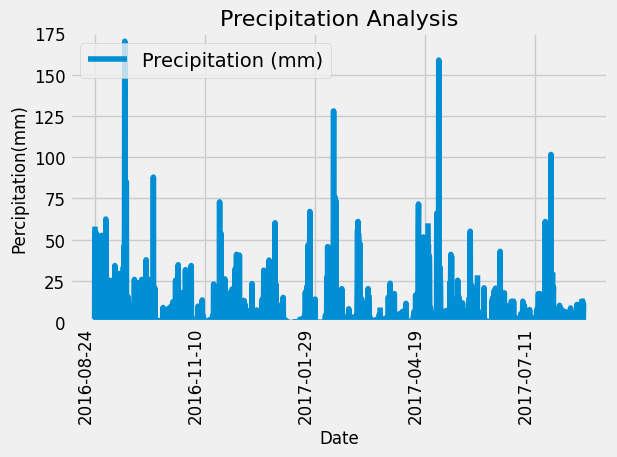

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
Last_Date = dt.date(2017,8,23) - dt.timedelta(days=365)

stmt = select(Measurement.prcp, Measurement.date).filter(Measurement.date > Last_Date).order_by(Measurement.date)
results = session.execute(stmt).all()

prcp_df = pd.DataFrame(results, columns=['Precipitation (mm)', 'Date'])
prcp_df.set_index('Date')
fig1 = plt.figure(figsize=(20,15))
prcp_df.plot('Date', 'Precipitation (mm)')
plt.grid(True)
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,175)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percipitation(mm)", fontsize=12)
plt.title("Precipitation Analysis", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation (mm)
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [10]:
# Design a query to calculate the total number of stations in the dataset
Total_Stations = session.scalar(select(func.count(Station.id)))
Total_Stations = session.scalar(select(func.count()).select_from(Station))
print(f"There are {Total_Stations} stations in the {Base.classes.keys()[1]} class")

There are 9 stations in the station class


In [11]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stmt_2 = select(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())
active_stations = session.execute(stmt_2).all()
print(f"Active stations as rcorded in {Base.classes.keys()[0]} class are displayed in descending order:")
for station, count in active_stations:
    print(f"Station id: {station}; Number of weather observations: {count}")

Active stations as rcorded in measurement class are displayed in descending order:
Station id: USC00519281; Number of weather observations: 2772
Station id: USC00519397; Number of weather observations: 2724
Station id: USC00513117; Number of weather observations: 2709
Station id: USC00519523; Number of weather observations: 2669
Station id: USC00516128; Number of weather observations: 2612
Station id: USC00514830; Number of weather observations: 2202
Station id: USC00511918; Number of weather observations: 1979
Station id: USC00517948; Number of weather observations: 1372
Station id: USC00518838; Number of weather observations: 511


In [12]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
Weather_station = active_stations[0][0]
stmt = select(func.min(Measurement.tobs).filter(Measurement.station == Weather_station),\
              func.max(Measurement.tobs).filter(Measurement.station == Weather_station),\
              func.avg(Measurement.tobs).filter(Measurement.station == Weather_station))
T_obs = session.execute(stmt).all()

print(f'At {Weather_station} station, the temperature ranges from {T_obs[0][0]}C (min) to {T_obs[0][1]}C (max), with an average Temperature of: {T_obs[0][2]}C')

At USC00519281 station, the temperature ranges from 12.2C (min) to 29.4C (max), with an average Temperature of: 22.03582251082252C


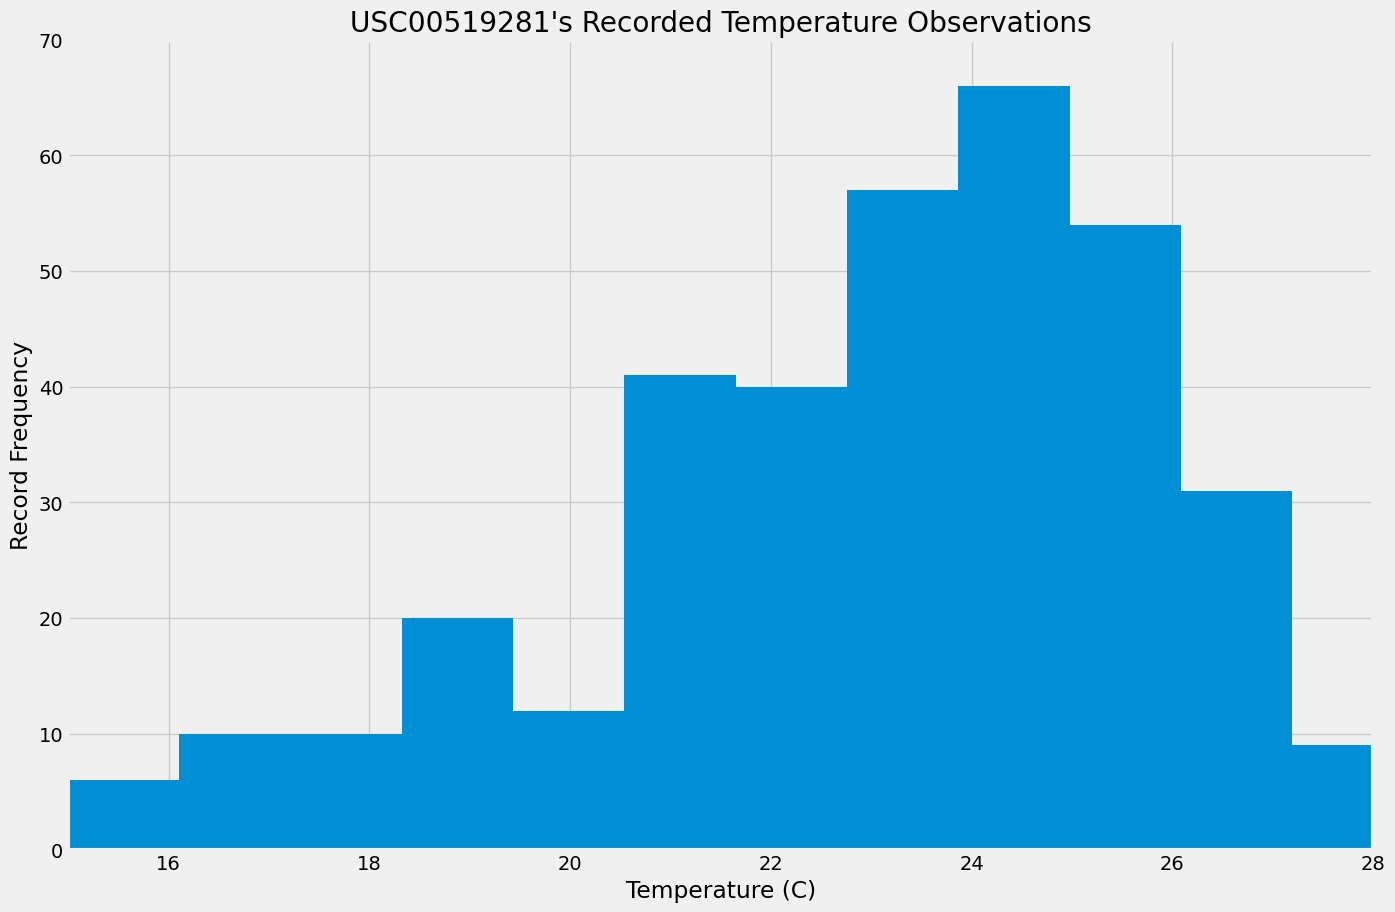

In [13]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stmt = select(Measurement.date).filter(Measurement.station == Weather_station).order_by(Measurement.date.desc()).limit(1)
recent_date=session.execute(stmt).first()

time_period = dt.date(2017,8,18) - dt.timedelta(days=365)

stmt = select(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == Weather_station).filter(Measurement.date > time_period).order_by(Measurement.date)
Temp_record = session.execute(stmt).all()

Temp_record_df = pd.DataFrame(Temp_record, columns = ['Station', 'Date', 'Temperature (c)'])
fig2 = plt.figure(figsize=(15,10))
plt.hist(Temp_record_df['Temperature (c)'], bins= 12, align = 'mid')
plt.grid(True)
plt.xlim(15,28)
plt.ylim(0,70)
plt.xlabel("Temperature (C)")
plt.ylabel("Record Frequency")
plt.title(f"{Weather_station}'s Recorded Temperature Observations")
plt.show()

# Close Session

In [14]:
# Close Session
session.close()